## Full workflow for my attempts at the Titanic challenge

### Submitted to: https://www.kaggle.com/competitions/titanic

#### This serves as the basis for cleanup and feature engineering. This notebook ends with a solution using gradient boosted trees that results in a score of 0.775 on the test data.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
import matplotlib.pyplot as plt
palette=sns.color_palette('magma')
sns.set(palette=palette)
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


## Import and EDA

In [2]:
train = pd.read_csv('../input/titanic/train.csv')
test = pd.read_csv('../input/titanic/test.csv')

### Check out the info and descriptive stats

In [3]:
print('INFO: TRAIN')
train.info()
print(50*'*')
print('INFO: TEST')
test.info()

INFO: TRAIN
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
**************************************************
INFO: TEST
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       -----

In [2]:
print('STATS: TRAIN')
train.describe()

STATS: TRAIN


NameError: name 'train' is not defined

In [5]:
train.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


### First pass at correlation to our target just to see what's going on.

In [6]:
print('Correlation WRT Survivorship')
train_corr=train.drop('PassengerId', axis=1).corr()
train_corr['Survived'].sort_values()

Correlation WRT Survivorship


Pclass     -0.338481
Age        -0.077221
SibSp      -0.035322
Parch       0.081629
Fare        0.257307
Survived    1.000000
Name: Survived, dtype: float64

### Since we know that sex is an important factor too, let's just take a looksie...

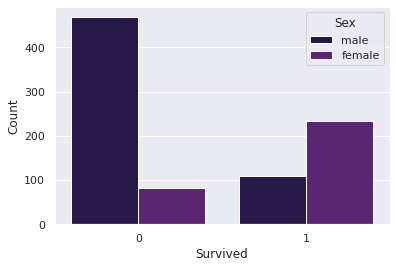

In [7]:
sns.countplot(train['Survived'], hue=train['Sex'])
plt.xlabel('Survived')
plt.ylabel('Count')
plt.show();

In [8]:
train[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


### Maybe explore some of the other properties too...

In [9]:
train[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [10]:
train[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


## Cleanup and Feature Engineering
### Plan of action:
1. Drop properties that aren't useful (Ticket) or lack too much data (Cabin)
2. Fill in missing values
3. Extract useful data from existing properties (Title from Name)
4. Dicretize continuous variables (Age and Fare)
5. Map integers onto non-int data
6. Drop redundant properties

### 1. Drop properties that aren't useful (Ticket) or lack too much data (Cabin)

In [12]:
train = train.drop(['Ticket', 'Cabin'], axis=1)
test = test.drop(['Ticket', 'Cabin'], axis=1)

### 2. Fill in missing values. Well, let's see what's missing!

In [13]:
print('MISSING DATA: TRAIN')
print(train.isna().sum())
print(30*'*')
print('MISSING DATA: TEST')
print(test.isna().sum())

MISSING DATA: TRAIN
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Fare             0
Embarked         2
dtype: int64
******************************
MISSING DATA: TEST
PassengerId     0
Pclass          0
Name            0
Sex             0
Age            86
SibSp           0
Parch           0
Fare            1
Embarked        0
dtype: int64


#### Function to fill in continuous values via ML. In this case, I've used SVM here for funsies...

In [14]:
from sklearn.svm import SVR, SVC, LinearSVC #Calling them all because I'll use them later
def svm_num(df,na_col): #pass in the dataset and either Age or Fare
    df=df.copy()
    
    num_df = df.select_dtypes(np.number) 
    val_cols = num_df.loc[:,num_df.isna().sum() == 0].columns
    
    y_train = num_df.loc[num_df[na_col].isna()==False,na_col] 
    X_train = num_df.loc[num_df[na_col].isna()==False,val_cols]
    X_test = num_df.loc[num_df[na_col].isna()==True,val_cols]
    
    svr = SVR()
    svr.fit(X_train,y_train)
    
    y_pred = svr.predict(X_test)
    
    df.loc[df[na_col].isna()==True,na_col] = y_pred
    
    return df

In [15]:
train=svm_num(train,'Age') #Use function to fill in age data in the train set

In [16]:
test=svm_num(test,'Age') #...and the test set

In [17]:
test=svm_num(test,'Fare') #And the missing fare value in the test set

#### There are still two missing values for the port of embarcation in the training set. Let's just fill them in with the mode.

In [18]:
port = train.Embarked.dropna().mode()[0]
train['Embarked'] = train['Embarked'].fillna(port)

In [19]:
#Yay, no missing data!
print('MISSING DATA: TRAIN')
print(train.isna().sum())
print(30*'*')
print('MISSING DATA: TEST')
print(test.isna().sum())

MISSING DATA: TRAIN
PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64
******************************
MISSING DATA: TEST
PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64


### 3. Extract useful data from existing properties (Title from Name)

In [20]:
all_data=[train,test]
for dataset in all_data:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.')

In [21]:
for dataset in all_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Other')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

#### Ooh yeah that looks promising...

In [22]:

train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Other,0.347826


### 4. Discretize continuous variables (Age and Fare)
#### Start with checking out the age distributions

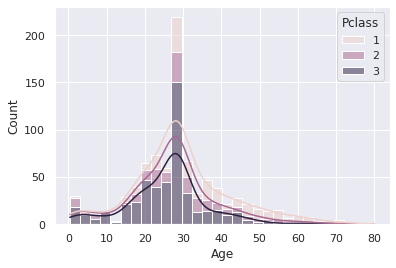

In [23]:
sns.histplot(data=train,x='Age',hue='Pclass',multiple='stack', kde=True);

#### Get some closer looks at various parts of the histogram

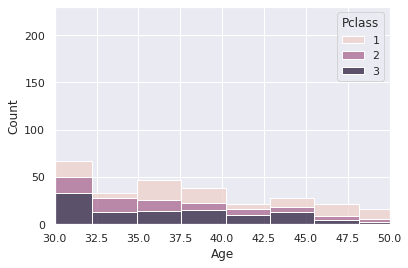

In [24]:
sns.histplot(data=train,x='Age',hue='Pclass',multiple='stack')
plt.xlim(left=30,right=50);

#### Separate age into categories

In [25]:
all_data=[train,test]
for dataset in all_data:    
    dataset.loc[ dataset['Age'] <= 12, 'Age'] = 0 #Child
    dataset.loc[(dataset['Age'] > 12) & (dataset['Age'] <= 19), 'Age'] = 1 #Teenager
    dataset.loc[(dataset['Age'] > 19) & (dataset['Age'] <= 30), 'Age'] = 2 #Young adult
    dataset.loc[(dataset['Age'] > 30) & (dataset['Age'] <= 50), 'Age'] = 3 #Adult
    dataset.loc[(dataset['Age'] > 50), 'Age'] = 4 #Older adult
    dataset['Age']=dataset['Age'].astype(int)

#### Onto fare...

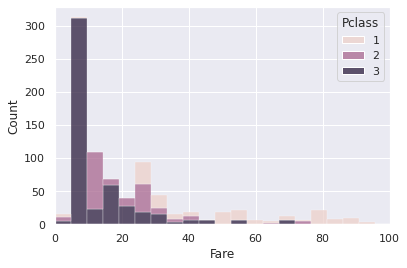

In [26]:
sns.histplot(data=train,x='Fare',hue='Pclass',multiple='stack')
plt.xlim(left=0,right=100);

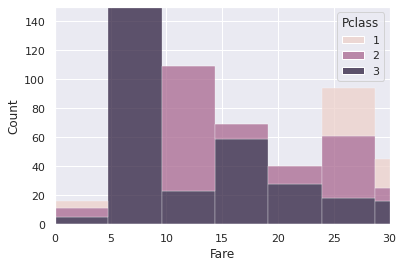

In [27]:
sns.histplot(data=train,x='Fare',hue='Pclass',multiple='stack')
plt.xlim(left=0,right=30)
plt.ylim(top=150);

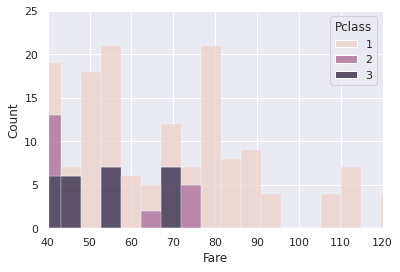

In [28]:
sns.histplot(data=train,x='Fare',hue='Pclass',multiple='stack')
plt.xlim(left=40,right=120)
plt.ylim(top=25);

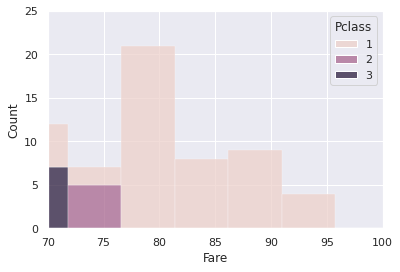

In [29]:
sns.histplot(data=train,x='Fare',hue='Pclass',multiple='stack')
plt.xlim(left=70,right=100)
plt.ylim(top=25);

#### As with age, let's split the continous fare data into discrete categories

In [30]:
all_data=[train,test]
for dataset in all_data:    
    dataset.loc[ dataset['Fare'] <= 10, 'Fare'] = 0 #Low
    dataset.loc[(dataset['Fare'] > 10) & (dataset['Fare'] <= 25), 'Fare'] = 1 #Middle
    dataset.loc[(dataset['Fare'] > 25) & (dataset['Fare'] <= 80), 'Fare'] = 2 #High
    dataset.loc[(dataset['Fare'] > 80), 'Fare'] = 3 #Super high
    dataset['Fare']=dataset['Fare'].astype(int)

### 5. Map integers onto non-int data. So that means Sex, Embarked, and Title.

In [31]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,2,1,0,0,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,3,1,0,2,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,2,0,0,0,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,3,1,0,2,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,3,0,0,0,S,Mr


#### Start with the Sex column

In [32]:
all_data=[train,test]
for dataset in all_data: 
    dataset['Sex'] = dataset['Sex'].map({'female': 1, 'male': 0}).astype(int)

#### Then Embarked...

In [33]:
all_data=[train,test]
for dataset in all_data:
    dataset['Embarked'] = dataset['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype(int)

#### And finally for Title, filling in those without a title with "0"

In [34]:
all_data=[train,test]
for dataset in all_data:
    dataset['Title'] = dataset['Title'].map({"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Other": 5}).astype(int)
    dataset['Title'] = dataset['Title'].fillna(0)

### 6. Drop redundant properties. We don't need PassengerID or Name in the datasets anymore. 
#### However, be sure to stick the test set's PassengerIDs elsewhere to tack it onto the submission file!

In [35]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",0,2,1,0,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,3,1,0,2,1,3
2,3,1,3,"Heikkinen, Miss. Laina",1,2,0,0,0,0,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,3,1,0,2,0,3
4,5,0,3,"Allen, Mr. William Henry",0,3,0,0,0,0,1


In [36]:
test_ids=test['PassengerId']

In [37]:
train = train.drop(['Name','PassengerId'], axis=1)
test = test.drop(['Name','PassengerId'], axis=1)

### Time for some ML!

In [38]:
from sklearn.model_selection import train_test_split
X=train.drop('Survived', axis=1)
y=train['Survived']

#### Split into test/training sets for the purpose of initial evaluation

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

#### A quick function to check out the performance of multiple models

In [40]:
from sklearn.metrics import classification_report, plot_roc_curve, plot_confusion_matrix, plot_precision_recall_curve
def report(model):
    preds = model.predict(X_test)
    print(classification_report(y_test,preds))

In [41]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression
log = LogisticRegression(max_iter=1000)
log.fit(X_train,y_train)

LogisticRegression(max_iter=1000)

In [42]:
#KNN
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train,y_train)

KNeighborsClassifier()

In [43]:
#The SVMs that we already called. Starting with a linear kernel
lsvc = LinearSVC()
lsvc.fit(X_train,y_train)

LinearSVC()

In [44]:
#...and then the radial
svc = SVC()
svc.fit(X_train,y_train)

SVC()

In [45]:
#Naive Bayes (multinomial)
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train,y_train)

MultinomialNB()

In [46]:
#And gaussian
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train,y_train)

GaussianNB()

In [47]:
#Let's bring some trees into the mix. First up, the Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
dtc.fit(X_train,y_train)

DecisionTreeClassifier()

In [48]:
#And the random forest
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)

RandomForestClassifier()

In [49]:
#Boosted trees starting with AdaBoost
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
ada = AdaBoostClassifier()
ada.fit(X_train,y_train)

AdaBoostClassifier()

In [50]:
#And everyone's favorite, the gradient boost
gbc = GradientBoostingClassifier()
gbc.fit(X_train,y_train)

GradientBoostingClassifier()

In [51]:
#Last, but not least, LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
lda.fit(X_train,y_train)

LinearDiscriminantAnalysis()

### Run them all!

In [52]:
print((30*'*')+'LOGISTIC REGRESSION'+(30*'*'))
report(log)
print((30*'*')+'K-NEIGHBORS'+(30*'*'))
report(knn)
print((30*'*')+'LINEAR SVC'+(30*'*'))
report(lsvc)
print((30*'*')+'SVC'+(30*'*'))
report(svc)
print((30*'*')+'NAIVE BAYES (Multinomial)'+(30*'*'))
report(nb)
print((30*'*')+'NAIVE BAYES (Gaussian)'+(30*'*'))
report(gnb)
print((30*'*')+'DECISION TREE'+(30*'*'))
report(dtc)
print((30*'*')+'RANDOM FOREST'+(30*'*'))
report(rfc)
print((30*'*')+'ADABOOSTING'+(30*'*'))
report(ada)
print((30*'*')+'GRADIENT BOOSTING'+(30*'*'))
report(gbc)
print((30*'*')+'LINEAR DISCRIMINANT ANALYSIS'+(30*'*'))
report(lda)

******************************LOGISTIC REGRESSION******************************
              precision    recall  f1-score   support

           0       0.79      0.91      0.85        99
           1       0.86      0.70      0.77        80

    accuracy                           0.82       179
   macro avg       0.83      0.80      0.81       179
weighted avg       0.82      0.82      0.81       179

******************************K-NEIGHBORS******************************
              precision    recall  f1-score   support

           0       0.78      0.89      0.83        99
           1       0.83      0.69      0.75        80

    accuracy                           0.80       179
   macro avg       0.81      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179

******************************LINEAR SVC******************************
              precision    recall  f1-score   support

           0       0.78      0.91      0.84        99
           1  

### None performed terribly, but let's look into SVC and gradient boosting a bit more with some grid searches.

In [53]:
from sklearn.model_selection import GridSearchCV

In [54]:
#Parameter grid for the SVC
svc_grid={
    'C':[0.001,0.01,0.1,0.5,1],
    'gamma':['scale','auto']
}

In [55]:
svc_gs = GridSearchCV(svc,svc_grid)

In [56]:
svc_gs.fit(X_train, y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.001, 0.01, 0.1, 0.5, 1],
                         'gamma': ['scale', 'auto']})

In [57]:
svc_gs.best_params_

{'C': 0.5, 'gamma': 'scale'}

In [58]:
#Parameter grid for Gradient boost. It's robust to high numbers of estimators, so let's go wild.
max_features = list(range(1,X.shape[1]))
gbc_grid= {
    'max_features':max_features,
    'n_estimators':[5,10,20,100,250],
    'max_depth':[3,4,5,6,7,8,9],
    'learning_rate':[0.01,0.05,0.1]
}

In [59]:
gbc_gs = GridSearchCV(gbc,gbc_grid)

In [60]:
gbc_gs.fit(X_train, y_train)

GridSearchCV(estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 4, 5, 6, 7, 8, 9],
                         'max_features': [1, 2, 3, 4, 5, 6, 7],
                         'n_estimators': [5, 10, 20, 100, 250]})

In [61]:
gbc_gs.best_params_

{'learning_rate': 0.05, 'max_depth': 4, 'max_features': 4, 'n_estimators': 20}

In [62]:
svc_model=SVC(C= 0.5, gamma='scale')
svc_model.fit(X_train,y_train)

SVC(C=0.5)

In [63]:
gbc_model=GradientBoostingClassifier(learning_rate=0.05, max_depth=4, max_features=6, n_estimators=20)
gbc_model.fit(X_train,y_train)

GradientBoostingClassifier(learning_rate=0.05, max_depth=4, max_features=6,
                           n_estimators=20)

In [64]:
print((30*'*')+'SVC'+(30*'*'))
report(svc_model)
print((30*'*')+'GRADIENT BOOSTING'+(30*'*'))
report(gbc_model)

******************************SVC******************************
              precision    recall  f1-score   support

           0       0.79      0.93      0.86        99
           1       0.89      0.70      0.78        80

    accuracy                           0.83       179
   macro avg       0.84      0.81      0.82       179
weighted avg       0.84      0.83      0.82       179

******************************GRADIENT BOOSTING******************************
              precision    recall  f1-score   support

           0       0.75      0.99      0.86        99
           1       0.98      0.60      0.74        80

    accuracy                           0.82       179
   macro avg       0.87      0.79      0.80       179
weighted avg       0.85      0.82      0.81       179



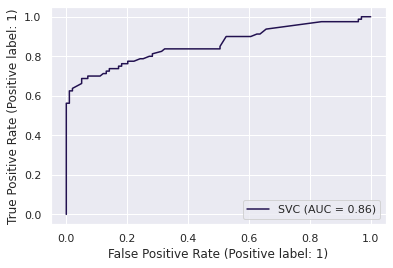

In [65]:
plot_roc_curve(svc_model, X_test, y_test)

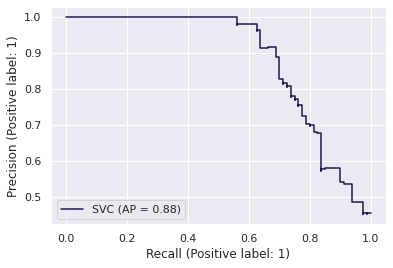

In [66]:
plot_precision_recall_curve(svc_model, X_test, y_test)

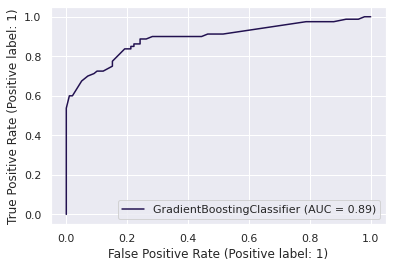

In [67]:
plot_roc_curve(gbc_model, X_test, y_test)

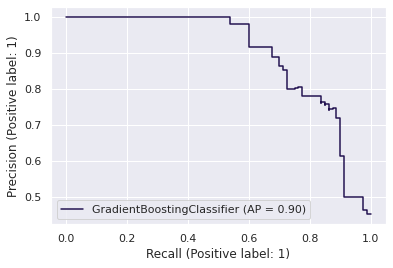

In [68]:
plot_precision_recall_curve(gbc_model, X_test, y_test)

#### Gradient boosting shows the highest AUC and AP. Sure, let's go with that for this round.

In [69]:
gbc_model.fit(X,y)

GradientBoostingClassifier(learning_rate=0.05, max_depth=4, max_features=6,
                           n_estimators=20)

In [70]:
final_preds=gbc_model.predict(test)
submission = pd.concat([test_ids,pd.Series(final_preds,name="Survived")],axis=1)
submission.to_csv("./submission.csv",index=False,header=True)

### Huzzah!